<a href="https://colab.research.google.com/github/alecorreia94/Analise_sentimentos_tweets/blob/main/twitter_analise_de_sentimento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1 INTRODUÇÃO**


A análise de sentimentos desempenha um papel fundamental na compreensão
das opiniões e emoções expressas pelos usuários nas redes sociais. A plataforma do Twitter, em particular, apresenta uma vasta quantidade de dados em tempo real, tornando-se um alvo interessante para pesquisas que envolvem análise sentimental. No entanto, as recentes políticas e restrições impostas pela API do Twitter têm gerado desafios significativos na extração direta desses dados.
Diante dessa problemática, este trabalho propõe uma abordagem para a análise de sentimentos de dados provenientes do Twitter.

A fim de superar as limitações impostas pela API do Twitter, utiliza-se uma base de dados disponível no Kaggle, composta por aproximadamente 5 mil tweets rotulados, coletados em 2018. Essa base de dados já possui rótulos para os sentimentos, sendo atribuído o valor 0 para sentimentos negativos, 1 para sentimentos positivos e 2 para sentimentos neutros. Para realizar a análise de sentimentos, optamos por empregar o modelo BERT (Bidirectional Encoder Representations from Transformers). O BERT é um modelo de linguagem pré-treinado, conhecido por sua capacidade de capturar relações contextuais entre palavras e fornecer representações de alta qualidade para tarefas de processamento de linguagem natural.

Utiliza-se também a variante "bert-base-portuguese-cased", conhecida como BERTimbau, que foi especialmente desenvolvida para o idioma português brasileiro. O BERTimbau Base é um modelo pré-treinado para o português brasileiro que alcança resultados de ponta em três tarefas de NLP (Processamento de Linguagem Natural): Reconhecimento de Entidades Nomeadas, Similaridade Textual de Frases e Reconhecimento de Inferência Textual. Ele está disponível em duas versões: Base e Large.

Este trabalho está organizado em sete seções principais além desta introdução. Na segunda seção apresenta-se os dados utilizada e descreve-se os procedimentos de coleta e preparação dos dados. A terceira seção trata da tokenização dos dados. Na quarta seção, apresenta-se os resultados obtidos ao aplicar o modelo BERT e a variante específica para a língua portuguesa. Na quinta seção é fornecida uma simples aplicação para testarmos o modelo na prática e torná-lo mais interativo. Por fim, na sexta apresenta-se as considerações finais em que discute-se as implicações e conclusões decorrentes dos resultados e na sétima as referências utilizadas para embasar a pesquisa e desenvolvimento deste trabalho.   


### **Instação da biblioteca transformers e outras bibliotecas necessárias**

In [ ]:
# instala o transformers
!pip install transformers

import pandas as pd  # Importa a biblioteca pandas para trabalhar com dados tabulares
import torch  # Importa a biblioteca PyTorch para treinar modelos de deep learning
import random  # Importa a biblioteca random para geração de números aleatórios
import numpy as np  # Importa a biblioteca numpy para trabalhar com matrizes numéricas
from sklearn.model_selection import train_test_split  # Importa a função train_test_split do scikit-learn para dividir os dados em treinamento e teste
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertModel  # Importa as classes e funções relacionadas ao modelo BERT da biblioteca transformers
from torch import nn  # Importa o módulo nn do PyTorch para definir redes neurais

# **2 DADOS**


Os dados utilizados neste projeto foram obtidos a partir do Kaggle (https://www.kaggle.com/datasets/debkings/tweetpt). O conjunto de dados original continha várias variáveis, incluindo id, tweet_text, tweet_date, sentiment e query_used. Para este projeto, fizemos um tratamento nos dados e mantivemos apenas as variáveis tweet_text e sentiment.

A variável tweet_text contém o texto do tweet, enquanto a variável sentiment representa os rótulos de sentimentos associados a cada tweet. Os rótulos de sentimentos são representados pelos valores 0, 1 e 2, que correspondem a sentimentos negativos, positivos e neutros, respectivamente.

In [ ]:
# Define a semente para reprodutibilidade
seed = 234
np.random.seed(seed)

# Lê os dados do Twitter a partir do arquivo CSV
twitter_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/twitter_data/tweet_data.csv',sep = ';')

## **2.1 Análise exploratória dos dados**




Abaixo é realizado uma amostragem aleatória de 1% dos dados do DataFrame twitter_data para não haver crash de memória e é exibido as primeiras linhas do DataFrame amostrado usando df.head() e df.shape para mostrar o tamanho do dataframe

In [ ]:
#Criação do dataframe
df = twitter_data.sample(frac=0.01).reset_index(drop=True)
df.head()

,tweet_text,sentiment
0,Base do governo quer investigar irregularidade...,2
1,gente eu to enjoada demais :(,0
2,Novato de 40 anos: Buffon solta a voz em trote...,2
3,eu tô como :( https://t.co/s2kg2QWeEc,0
4,Considerado o maior especialista em manuscrito...,2


In [ ]:
#tamanho do DataFrame
df.shape

(50, 2)

Abaixo temos um gráfico de barras que exibe a contagem dos diferentes sentimentos dos tweets presentes no DataFrame df. Os sentimentos são representados no eixo x e a altura das barras indica a contagem de tweets para cada sentimento.


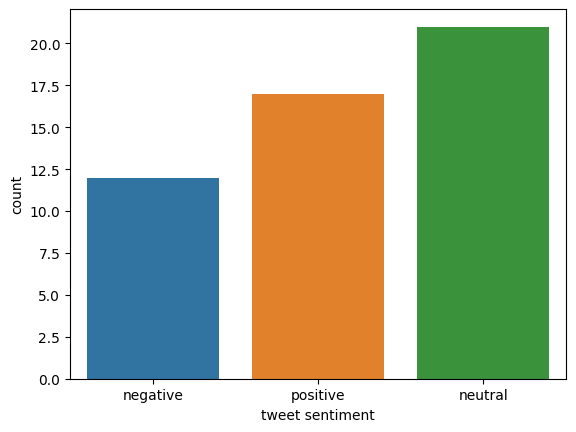

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
ax=sns.countplot(x=df["sentiment"])
class_names = ['negative', 'positive', 'neutral']
plt.xlabel('tweet sentiment')
ax.set_xticklabels(class_names);

Aqui são dividos os dados em conjuntos de treinamento e teste usando a função train_test_split. Os textos dos tweets são armazenados nas variáveis train_text e test_text, enquanto os rótulos de sentimentos são armazenados nas variáveis train_labels e test_labels. A divisão é feita de forma aleatória, preservando a distribuição dos sentimentos nos conjuntos.

In [ ]:
#partição dos dados
train_text, test_text, train_labels, test_labels = train_test_split(df['tweet_text'], df['sentiment'],
                                                                    random_state=42,
                                                                    test_size=0.3,
                                                                    stratify=df['sentiment'])

# **3 FUNCIONAMENTO DO MODELO BERT**

## **3.1 Processo de tokenização dos dados textuais**

Nessa parte usa-se o modelo pré-treinado BERT para o idioma português e o tokenizador associado a esse modelo. Em seguida, seleciona-se um exemplo de texto de tweet do DataFrame e o tokenizamos usando o tokenizador. Em seguida, imprime o texto original do tweet, os tokens resultantes e seus IDs correspondentes. Isso nos ajuda a entender o processo de tokenização e como os textos são representados pelo modelo BERT.

In [ ]:
#tokenizador do BERTimbau

PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

sample_txt = df.tweet_text[1]

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: gente eu to enjoada demais :(
   Tokens: ['gente', 'eu', 'to', 'en', '##jo', '##ada', 'demais', ':', '(']
Token IDs: [9349, 2779, 374, 432, 1286, 251, 3547, 131, 113]


Para cumprir os requisitos de entrada do BERT é preciso criar vetores de 0s e 1s chamados attention mask, que indicam quais token devem ser considerados como válidos, e adicionar mais três tokens especiais nos textos:

[SEP] (102)- Marca o fim de uma frase

[CLS] (101)- Deve ser colocado no inicio de cada frase para o BERT saber que trata-se de um problema de classificação.

[PAD] (0)- Tokens de valor 0 que devem ser adicionados às sentenças para garantir que todas tenham o mesmo tamanho




Dessa forma, usa-se tokenizador BERT para codificar o texto de um tweet. Define-se opções como o comprimento máximo da sequência, adição de tokens especiais, criação de máscara de atenção e retorno dos resultados como tensores do PyTorch. O objeto encoding contém as informações codificadas, e ao chamar encoding.keys(), podemos ver as chaves disponíveis nesse objeto.

In [ ]:
#criação dos tokens
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=100,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

**IDs dos tokens**: Os IDs dos tokens agora estão armazenados em um tensor e foram preenchidos para um comprimento de 100. Essas informações são úteis para entender o tamanho da sequência e visualizar como o texto do tweet foi representado numericamente.

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

100


tensor([ 101, 9349, 2779,  374,  432, 1286,  251, 3547,  131,  113,  102,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])

**Máscara de atenção**: abaixo tem-se o comprimento da máscara de atenção e a própria máscara de atenção em si. A máscara de atenção indica quais tokens são de preenchimento (0) e quais são tokens reais (1) na sequência de tokens.

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

100


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

**Tokens especiais**: Essa linha de código converte os IDs dos tokens de volta para suas representações de texto usando o tokenizador BERT. Isso nos permite visualizar os tokens originais associados aos IDs dos tokens.

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'gente', 'eu', 'to', 'en', '##jo', '##ada', 'demais', ':', '(', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


## **3.2 Escolhendo o comprimento da sequência**

Como o BERT trabalha com um tamanho fixo de entrada, um dos parâmetros chave durante o processo de tokenização é a escolha do valor máximo dessa entrada (max_length).

Esse valor será definido analisando a distribuição dos tokens presentes no dataset. Como a maioria deles tem um tamanho menor que 60, será escolhido um max_lenght de 120 apenas para garantir que todos os casos serão cobertos.


### **3.2.1 Gráfico de densidade de tokens**

Logo abaixo encontra-se um gráfico de distribuição desse número. O gráfico nos permite visualizar como os textos de tweet estão distribuídos em termos de contagem de tokens.

<ipython-input-76-4d6f0c826d8f>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


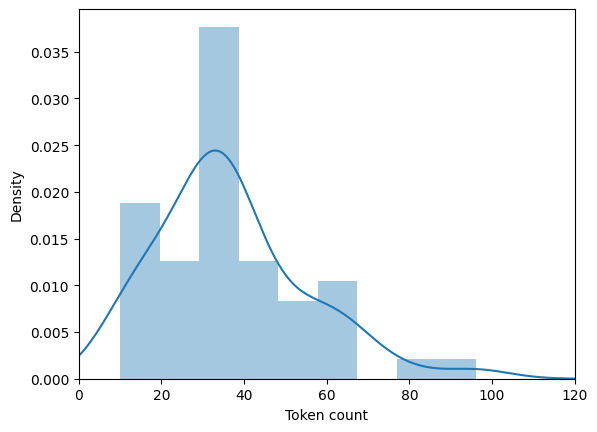

In [ ]:
#Tamanho dos tokens
token_lens = []

for txt in df.tweet_text:
  tokens = tokenizer.encode(txt, max_length=120)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 120]);
plt.xlabel('Token count');

Abaixo utiliza-se o tokenizador BERT para codificar os textos de treinamento e teste. As configurações incluem truncamento, preenchimento e limitação do comprimento máximo da sequência. Em seguida, exibe-se informações sobre o primeiro exemplo de treinamento, incluindo o texto original, os tokens resultantes, os IDs dos tokens e a decodificação dos IDs de volta para o texto original.

In [ ]:
#tokenizador BERT para codificar os textos de treinamento e teste
max_len=120
train_encodings = tokenizer(list(train_text), truncation=True, padding=True, max_length=max_len,return_tensors="pt")
test_encodings = tokenizer(list(test_text), truncation=True, padding=True, max_length=max_len,return_tensors="pt")

#imprime o primeiro tweet de treino codificado
print(list(train_text)[0])
tokenizer.tokenize(list(train_text)[0] )[:max_len]
train_encodings.input_ids[0]
tokenizer.decode(train_encodings.input_ids[0] )

@miIatears ai cara :(( tadinha da minha bichinha pqp


'[CLS] @ miIatears ai cara : ( ( tadinha da minha bichinha pqp [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

# **4 RESULTADOS**

### **4.1 Treinamento e avaliação do modelo**

Abaixo temos o cálculo para acurácia do modelo e, em seguida, iniciam o histórico de treinamento e os parâmetros necessários. Em seguida, um loop é executado para treinar e validar o modelo em cada época. Durante cada época, a função de perda é calculada, os parâmetros são atualizados e as métricas de treinamento e validação são calculadas. O histórico é atualizado e o melhor modelo é salvo com base na acurácia de validação. Essas linhas de código permitem treinar o modelo BERT para classificação de sequências e monitorar seu desempenho ao longo do tempo.

Devido a limitação de memória e GPU dedicada só foi possível gerar resultados de até 4 épocas.

In [ ]:
# Definindo a função para calcular a acurácia
def calculate_accuracy(model, encodings, labels):
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)
        accuracy = (predicted_labels == labels).sum().item() / len(labels)
    return accuracy

# Inicializando o histórico de treinamento
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Inicializando o modelo e otimizador
model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=3)
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 4

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    print("-" * 10)

    # Treinamento
    model.train()
    labels = torch.tensor(list(train_labels))
    train_loss = model(**train_encodings, labels=labels).loss
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Cálculo da acurácia de treinamento
    train_accuracy = calculate_accuracy(model, train_encodings, labels)
    print(f"Train loss: {train_loss:.5f} accuracy: {train_accuracy:.5f}")

    # Validação
    model.eval()
    val_labels = torch.tensor(list(test_labels))
    val_loss = model(**test_encodings, labels=val_labels).loss

    # Cálculo da acurácia de validação
    val_accuracy = calculate_accuracy(model, test_encodings, val_labels)
    print(f"Val loss: {val_loss:.5f} accuracy: {val_accuracy:.5f}")
    print()

    # Atualização do histórico
    history['train_acc'].append(train_accuracy)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_accuracy)
    history['val_loss'].append(val_loss)

    # Salvando o melhor modelo com base na acurácia de validação
    if val_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_accuracy

'''
# Essas linhas de código abaixo executam o treinamento e a avaliação do modelo BERT
para classificação de sequências. O modelo é treinado por várias épocas,
onde a função de perda é calculada e os parâmetros são atualizados com o otimizador.
Em seguida, o modelo é avaliado usando os dados de validação, calculando a função de perda novamente.
Os resultados são exibidos para cada época.

é uma alternativa mas adaptei para também verificar a acurácia do modelo

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)


epochs = 5

for epoch in range(epochs):
    print("Training")
    model.train()
    labels = torch.tensor(list(train_labels))
    train_loss = model(**train_encodings, labels=labels).loss
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch} | Loss: {train_loss:.5f}")

    model.eval()
    print("Evaluation")
    with torch.inference_mode():
        val_labels = torch.tensor(list(test_labels))
        val_loss = model(**test_encodings, labels=val_labels).loss
        print(f"Epoch: {epoch} | train Loss: {train_loss:.5f} | val Loss: {val_loss:.5f}")
        print("_____________________________")'''



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4
----------
Train loss: 1.14593 accuracy: 0.31429
Val loss: 1.11172 accuracy: 0.33333

Epoch 2/4
----------
Train loss: 1.07682 accuracy: 0.60000
Val loss: 1.05626 accuracy: 0.40000

Epoch 3/4
----------
Train loss: 1.02869 accuracy: 0.77143
Val loss: 1.02570 accuracy: 0.53333

Epoch 4/4
----------
Train loss: 0.98412 accuracy: 0.71429
Val loss: 1.00154 accuracy: 0.60000



'\n# Essas linhas de código abaixo executam o treinamento e a avaliação do modelo BERT\npara classificação de sequências. O modelo é treinado por várias épocas,\nonde a função de perda é calculada e os parâmetros são atualizados com o otimizador.\nEm seguida, o modelo é avaliado usando os dados de validação, calculando a função de perda novamente.\nOs resultados são exibidos para cada época. \n\né uma alternativa mas adaptei para também verificar a acurácia do modelo\n\nrandom.seed(seed)\nnp.random.seed(seed)\ntorch.manual_seed(seed)\n\nmodel = BertForSequenceClassification.from_pretrained(\'bert-base-uncased\', num_labels=3)\n\noptimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)\n\n\nepochs = 5\n\nfor epoch in range(epochs):\n    print("Training")\n    model.train()\n    labels = torch.tensor(list(train_labels))\n    train_loss = model(**train_encodings, labels=labels).loss\n    optimizer.zero_grad()\n    train_loss.backward()\n    optimizer.step()\n    print(f"Epoch: {epoch} | L

Observa-se que ao final das 4 épocas a acurácia de teste começa a aumentar, infelizmente por conta da limitação de memória não consegue-se expandir as épocas. Ajustando os parâmetros, o modelo pode ficar ainda melhor, mas acredito que esses resultados são suficientes para o propósito desse projeto

In [ ]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## **4.2 Gráfico do progresso de acurácia**

O gráfico abaixo permite visualizar a progressão da acurácia do modelo ao longo das épocas de treinamento e validação.

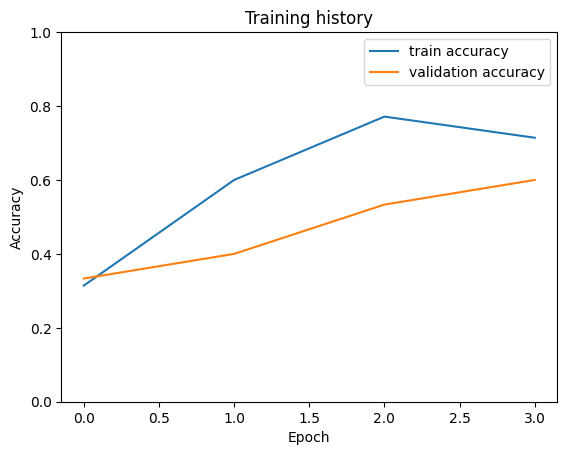

In [ ]:
import matplotlib.pyplot as plt

# Plotando a acurácia de treinamento e validação
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Configurações do gráfico
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

# Exibindo o gráfico
plt.show()

O gráfico mostra que a acurácia do modelo está crescendo ao decorrer do processo de validação. Nota-se que o modelo melhora seu desempenho ao longo das épocas de treinamento. A perda de treinamento diminui progressivamente e a precisão aumenta. No entanto, a precisão na validação varia em cada época, alcançando uma precisão máxima de 0.60. Além disso, podemos notar pelos resultados anteriores que a função perda vem diminuindo ao acrescentar mais épocas.

## **4.3 Matriz de Confusão**


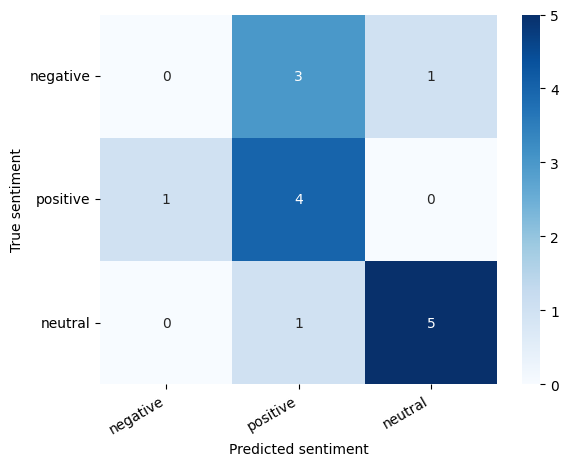

In [ ]:
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

# Cálculo da matriz de confusão
y_pred = torch.argmax(model(**test_encodings).logits, dim=1)
cm = confusion_matrix(val_labels, y_pred)

# Exibição da matriz de confusão
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)



 Mesmo com valores pequenos devido à limitação de memória  e a base curta de apenas 50 tweets que puderam ser utilizado e um total de 15 tweets utilizados na validação. Temos a performance do modelo de classificação

Analisando os resultados, observa-se que o modelo apresenta uma melhor capacidade de classificar corretamente os tweets positivos e neutros, com uma taxa de acerto mais alta para essas classes. No entanto, o modelo possui uma taxa de erro relativamente maior ao classificar tweets como positivos, quando na realidade eles são neutros.

Essa análise indica que o modelo pode ter uma tendência a classificar incorretamente alguns tweets neutros como positivos. Essa observação é importante para entender as características e os padrões que o modelo está considerando para classificar os tweets e pode fornecer insights sobre possíveis melhorias no desempenho do modelo.

É importante ressaltar que, devido à limitação de memórias esses números podem ser imprecisos, é necessário considerar esses resultados com cautela e realizar uma análise mais aprofundada alterando esses valores quando possível.

# **5 TESTE DO MODELO**

## **5.1 Uma pequena aplicação para testar o modelo**

Logo abaixo, temos uma simples aplicação para deixar o modelo mais interativo e mais aplicável. Portanto, podemos digitar qualquer frase curta de no máximo 120 palavras e o modelo responderá se esta frase possui sentimentos negativo, positivo ou neutro. Dessa forma, este modelo pode ser aplicado para diferentes áreas, na economia poderiamos utilizá-lo para verificar o sentimento das pessoas em relação a alguma possível atualização nas leis que regem a economia, ou propostas de governo.

In [ ]:
#movendo tensores para algum dispositivo GPU ou CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def classify_sentiment(text):
    encoded_text = tokenizer.encode_plus(
        text,
        max_length=max_len,
        add_special_tokens=True,
        return_token_type_ids=False,
        padding='longest',
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    logits = output.logits
    probabilities = torch.softmax(logits, dim=1)
    sentiment_probs = probabilities[0].tolist()
    sentiment_index = torch.argmax(logits, dim=1).item()
    sentiment_label = class_names[sentiment_index]

    return sentiment_probs, sentiment_label

user_text = input("Digite um texto: (e tecle enter]) ")
sentiment_probs, sentiment_label = classify_sentiment(user_text)
sentiment_labels = pd.DataFrame(sentiment_probs, class_names)[0]

print(f"Texto: {user_text}")
print(f"Probabilidades de sentimento:\n{sentiment_labels}")
print(f"Sentimento mais provável: {sentiment_label}")


Digite um texto: (e tecle enter]) muito bom
Texto: muito bom
Probabilidades de sentimento:
negative    0.339977
positive    0.343596
neutral     0.316428
Name: 0, dtype: float64
Sentimento mais provável: positive


Por conta da pequena base treinada e a escolha do modelo não ser o de melhor acurácia pela limitação computacional o modelo pode prever erroneamente algumas vezes.

# **6 CONSIDERAÇÕES FINAIS**

Este trabalho explorou o uso do modelo BERT pré-treinado para o português brasileiro, conhecido como BERTimbau, na tarefa de análise de sentimentos. O modelo utilizado foi o BERT-base-portuguese-cased. Devido às limitações de recursos computacionais, como memória e GPU, o treinamento do modelo foi realizado por apenas 4 épocas, utilizando uma amostra de 50 tweets com seus respectivos rótulos. Essa amostra correspondeu a apenas 1% dos dados disponíveis na base original.

Apesar das restrições mencionadas, os resultados obtidos foram promissores. No entanto, é importante destacar que a generalização e a precisão do modelo poderiam ser aprimoradas com o uso de um conjunto de dados maior e o aumento dos recursos computacionais disponíveis. Além disso, a impossibilidade de acessar em tempo real a API do Twitter limitou a obtenção de dados mais recentes.

Para contornar essas limitações, foi utilizada uma base de dados previamente disponível, que já possuía rótulos atribuídos e colunas irrelevantes removidas. Em trabalhos futuros, sugere-se explorar outras estratégias de coleta de dados. Embora tenha sido possível concluir com êxito o objetivo de realizar a análise de sentimentos com dados do Twitter, a análise de sentimentos relacionados a frases sobre economia e tecnologias assistivas ficará para um próximo passo. É importante ressaltar que, ao obter uma amostra de dados específica para esses temas, é possível obter resultados mais precisos ao analisar o sentimento relacionado a eles.

Apesar das limitações enfrentadas, os resultados obtidos até o momento forneceram insights preliminares e abrem caminho para futuras pesquisas nessas áreas. Para dar continuidade a esse trabalho, seria necessário expandir a amostra de dados, ajustar parâmetros adicionais e realizar uma análise mais aprofundada dos resultados obtidos.

Em resumo, embora este estudo tenha apresentado resultados promissores considerando as limitações enfrentadas, existem oportunidades para melhorar o desempenho do modelo por meio do aumento dos recursos computacionais disponíveis e da obtenção de dados mais representativos.

# **7 REFERÊNCIAS**

Devlin, J., Chang, M.-W., Lee, K., & Toutanova, K. (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. arXiv preprint arXiv:1810.04805. Recuperado de https://arxiv.org/abs/1810.04805

Hansen, S., Lambert, P. J., Bloom, N., Davis, S. J., Sadun, R., & Taska, B. (2023). Remote work across jobs, companies, and space (Working Paper 31007). Recuperado de http://www.nber.org/papers/w31007

Hugging Face. (n.d.). neuralmind/bert-base-portuguese-cased. Recuperado de https://huggingface.co/neuralmind/bert-base-portuguese-cased


Kings, D. (Atualizado há 4 anos). tweetpt: Análise de Sentimentos - Tweets - Português. Kaggle. Recuperado de https://www.kaggle.com/datasets/debkings/tweetpt

Souza, F. C. (2020). BERTimbau: pretrained BERT models for Brazilian Portuguese [Tese de doutorado, Universidade Estadual de Campinas].

Souza, F., Nogueira, R., & Lotufo, R. (2020). BERTimbau: pretrained BERT models for Brazilian Portuguese. In Proceedings of the Conference Name or Journal Name, Volume(Issue)

Vaswani, Ashish, et al. “Attention is all you need.” arXiv preprint arXiv:1706.03762 (2017)

Zanini, H. (2021, 1 de novembro). Análise de sentimentos em português utilizando Pytorch e Python. Data Hackers. Recuperado de https://medium.com/data-hackers/an%C3%A1lise-de-sentimentos-em-portugu%C3%AAs-utilizando-pytorch-e-python-91a232165ec0


